# MATH pre-train vs RL evaluation visualization

Use this notebook to collect GSM8K evaluation scores from pre-training and RL runs under `/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results`, then plot how RL fine-tuning moves performance from its starting checkpoint.



In [1]:
from pathlib import Path
import re
import ast
import pandas as pd
import matplotlib.pyplot as plt

# Root location for evaluation outputs and the metric key to read
BASE_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results")
ADDITIONAL_RL_DIR = Path("/n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny_tmp")
DATASET_KEY = "test_score/DigitalLearningGmbH/MATH-lighteval"
DATASET_NAME = "MATH"

print(f"Base directory: {BASE_DIR}")
print(f"Additional RL directory: {ADDITIONAL_RL_DIR}")

Base directory: /n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results
Additional RL directory: /n/netscratch/dam_lab/Everyone/rl_pretrain/eval_results_sunny_tmp


In [2]:
def read_score(result_path: Path, samples: int, dataset_key: str = DATASET_KEY):
    """Read score from either dict-style logs or majority-vote text.

    - For majority files (samples > 1 or filename contains 'majority'), look for a line
      containing 'Pass@' and take the first float after the colon.
    - Otherwise, look for the last dict line containing the dataset_key.
    """
    if not result_path.exists():
        return None

    text = result_path.read_text().splitlines()

    # Majority-format text file (pass@k, single-sample accuracy, etc.)
    if samples > 1 or "majority" in result_path.name:
        for line in text:
            if "Pass@" in line:
                # Expect formats like: "Pass@32 (Any Correct):            0.6884 (68.84%)"
                parts = line.split(":")
                if len(parts) > 1:
                    try:
                        return float(parts[1].split()[0])
                    except Exception:
                        pass
                # Fallback: grab first float on the line
                import re as _re
                match = _re.search(r"([0-9]*\.?[0-9]+)", line)
                if match:
                    try:
                        return float(match.group(1))
                    except Exception:
                        pass
        # If we didn't find Pass@, fall back to the dict parsing below

    # Dict-style log: scan from the bottom for a dict containing the key
    for line in reversed(text):
        try:
            payload = ast.literal_eval(line.strip())
        except Exception:
            continue
        if isinstance(payload, dict) and dataset_key in payload:
            return payload[dataset_key]
    return None

def collect_runs_from_directory(directory: Path, collect_pretrain=True, collect_rl=True, collect_sft=True):
    """Collect pretrain, RL, and SFT runs from a directory."""
    pretrain_rows = []
    rl_rows = []
    sft_rows = []
    
    # Pre-train pattern
    pre_pattern = re.compile(r"1B-step(?P<step>\d+)-(?P<shot>\d+)shot-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$")
    
    # RL patterns
    rl_patterns = [
        re.compile(r"1B-step(?P<pt_step>\d+)-rl-step(?P<rl_step>\d+)-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
        re.compile(r"olmo2_1b_step(?P<pt_step>\d+)_omi_n(?P<num_rollouts>\d+)-step(?P<rl_step>\d+)-rl-0shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$"),
    ]
    
    # SFT patterns
    sft_patterns = [
        re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
        re.compile(r"OLMo2-1B-step(?P<pt_step>\d+)-stage2-openmathgsm8k-5epoch-step(?P<sft_step>\d+)-hf-(?P<shot>\d+)shot-boxed-(?P<samples>\d+)samples-temp(?P<temp>[\d.]+)$", re.IGNORECASE),
    ]
    
    if not directory.exists():
        print(f"Warning: Directory {directory} does not exist, skipping...")
        return pretrain_rows, rl_rows, sft_rows
    
    for path in directory.iterdir():
        if not path.is_dir():
            continue
        name = path.name

        # Pre-train collection
        if collect_pretrain:
            pre_match = pre_pattern.match(name)
            if pre_match and not any(tag in name for tag in ["-rl-", "-sft-", "-hf"]):
                samples = int(pre_match.group("samples"))
                result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
                score = read_score(path / result_file, samples=samples)
                pretrain_rows.append(
                    {
                        "step": int(pre_match.group("step")),
                        "shot": int(pre_match.group("shot")),
                        "samples": samples,
                        "temp": float(pre_match.group("temp")),
                        "score": score,
                        "path": str(path),
                    }
                )
                continue

        # RL collection
        if collect_rl:
            matched = False
            for pat in rl_patterns:
                rl_match = pat.match(name)
                if rl_match:
                    samples = int(rl_match.group("samples"))
                    result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
                    score = read_score(path / result_file, samples=samples)
                    pt_step = int(rl_match.group("pt_step"))
                    rl_step = int(rl_match.group("rl_step"))
                    
                    # Extract num_rollouts if available in the pattern
                    num_rollouts = None
                    if "num_rollouts" in rl_match.groupdict():
                        num_rollouts = int(rl_match.group("num_rollouts")) if rl_match.group("num_rollouts") else None
                    
                    rl_rows.append(
                        {
                            "pt_step": pt_step,
                            "rl_step": rl_step,
                            "total_step": pt_step + rl_step,
                            "samples": samples,
                            "temp": float(rl_match.group("temp")),
                            "score": score,
                            "path": str(path),
                            "label": name,
                            "num_rollouts": num_rollouts,
                        }
                    )
                    matched = True
                    break
            if matched:
                continue

        # SFT collection
        if collect_sft:
            for pat in sft_patterns:
                sft_match = pat.match(name)
                if sft_match:
                    samples = int(sft_match.group("samples"))
                    shot = int(sft_match.group("shot")) if "shot" in sft_match.groupdict() else None
                    result_file = "math_majority_results.txt" if samples > 1 else "math_results.txt"
                    score = read_score(path / result_file, samples=samples)
                    pt_step = int(sft_match.group("pt_step"))
                    sft_step = int(sft_match.group("sft_step"))
                    if "5epoch" in name:
                        epochs = 5
                    else:
                        epochs = 1
                    sft_rows.append(
                        {
                            "pt_step": pt_step,
                            "sft_step": sft_step,
                            "total_step": pt_step + sft_step,
                            "shot": shot,
                            "samples": samples,
                            "temp": float(sft_match.group("temp")),
                            "score": score,
                            "path": str(path),
                            "label": name,
                            "sft_epochs": epochs,
                        }
                    )
                    break
    
    return pretrain_rows, rl_rows, sft_rows

# Collect from main directory (pretrain, RL, SFT)
print(f"Collecting from {BASE_DIR}...")
pretrain_rows, rl_rows, sft_rows = collect_runs_from_directory(BASE_DIR, collect_pretrain=True, collect_rl=True, collect_sft=True)

# Collect from additional RL directory (only RL) - keep separate for now
print(f"Collecting RL runs from {ADDITIONAL_RL_DIR}...")
_, additional_rl_rows, _ = collect_runs_from_directory(ADDITIONAL_RL_DIR, collect_pretrain=False, collect_rl=True, collect_sft=False)

# Create separate dataframes
pre_df = pd.DataFrame(pretrain_rows)
rl_df = pd.DataFrame(rl_rows)
rl_df_sunny = pd.DataFrame(additional_rl_rows)
sft_df = pd.DataFrame(sft_rows)

print(f"Loaded {len(pre_df)} pre-train runs, {len(rl_df)} RL runs from main dir, {len(rl_df_sunny)} RL runs from sunny dir, {len(sft_df)} SFT runs.")

Loaded 139 pre-train runs, 414 RL runs from main dir, 251 RL runs from sunny dir, 63 SFT runs.


In [3]:
display(pre_df.sort_values(["step", "shot", "samples", "temp"]))
print()
display(rl_df.sort_values(["pt_step", "rl_step", "samples", "temp"]))
print()
display(sft_df.sort_values(["pt_step", "sft_step", "samples", "temp"]))



,step,shot,samples,temp,score,path
1,1000,0,1,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
3,1000,0,8,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
2,1000,0,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
0,1000,0,128,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
5,1000,1,1,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
...,...,...,...,...,...,...
76,22000,8,8,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
77,22000,8,8,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
74,22000,8,32,0.0,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...
75,22000,8,32,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...


,pt_step,rl_step,total_step,samples,temp,score,path,label,num_rollouts
98,1000,100,1100,1,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n5-step100-rl-0shot-boxe...,5.0
174,1000,100,1100,1,0.6,0.0328,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...,64.0
100,1000,100,1100,5,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n5-step100-rl-0shot-boxe...,5.0
101,1000,100,1100,8,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n5-step100-rl-0shot-boxe...,5.0
176,1000,100,1100,8,0.6,0.0664,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step1000_omi_n64-step100-rl-0shot-box...,64.0
...,...,...,...,...,...,...,...,...,...
298,22000,2100,24100,5,0.6,0.0926,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2100-rl-0shot-bo...,5.0
299,22000,2200,24200,1,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2200-rl-0shot-bo...,5.0
301,22000,2200,24200,5,0.6,NaN,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2200-rl-0shot-bo...,5.0
302,22000,2200,24200,8,0.6,0.1012,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,olmo2_1b_step22000_omi_n5-step2200-rl-0shot-bo...,5.0


,pt_step,sft_step,total_step,shot,samples,temp,score,path,label,sft_epochs
33,3000,285,3285,0,1,0.0,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
35,3000,285,3285,0,8,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
34,3000,285,3285,0,32,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
32,3000,285,3285,0,128,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-step285...,1
28,3000,1389,4389,0,1,0.0,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step3000-stage2-openmathgsm8k-5epoch-...,5
...,...,...,...,...,...,...,...,...,...,...
19,22000,1389,23389,0,1,0.0,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
20,22000,1389,23389,0,1,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
22,22000,1389,23389,0,8,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5
21,22000,1389,23389,0,32,0.6,None,/n/netscratch/dam_lab/Everyone/rl_pretrain/eva...,OLMo2-1B-step22000-stage2-openmathgsm8k-5epoch...,5


In [4]:
# Drop NA rows
rl_df = rl_df.dropna()
rl_df_sunny = rl_df_sunny.dropna()

# Merge RL dataframes
print(f"Before merge: {len(rl_df)} main RL runs, {len(rl_df_sunny)} sunny RL runs")
rl_df_combined = pd.concat([rl_df, rl_df_sunny], ignore_index=True)

# Remove duplicates based on all columns except 'path' and 'label'
# These columns identify the actual data, so if they match, it's a duplicate
duplicate_check_cols = ['pt_step', 'rl_step', 'total_step', 'samples', 'temp', 'score', 'num_rollouts']
rl_df = rl_df_combined.drop_duplicates(subset=duplicate_check_cols, keep='first')

print(f"After merge and dedup: {len(rl_df)} total RL runs ({len(rl_df_combined) - len(rl_df)} duplicates removed)")
print(f"Final: {len(pre_df)} pre-train runs, {len(rl_df)} RL runs, {len(sft_df)} SFT runs.")

Before merge: 153 main RL runs, 100 sunny RL runs
After merge and dedup: 187 total RL runs (66 duplicates removed)
Final: 139 pre-train runs, 187 RL runs, 63 SFT runs.


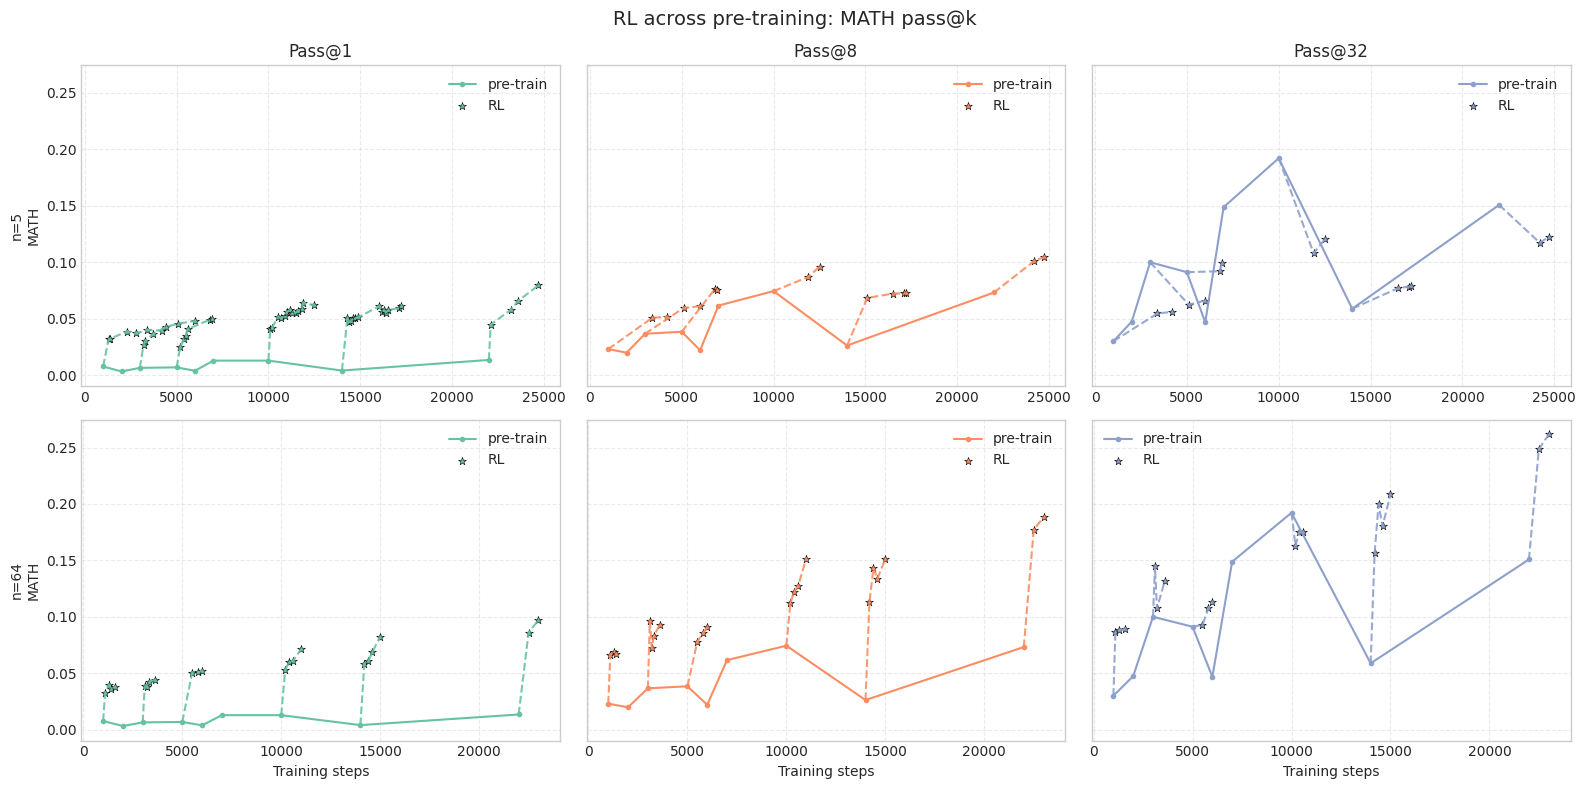

In [5]:
# Refined plotting: per-k subplots, cleaner legend markers, no RL/SFT marker at start
PLOT_SAMPLES = [1, 8, 32]
BASE_PRETRAIN_SHOT = 1
SHOT_BY_SAMPLES = lambda s: BASE_PRETRAIN_SHOT
TEMP_BY_SAMPLES = lambda s: 0.6
FILTER_NUM_ROLLOUTS_LIST = [5, 64]  # Plot both n=5 and n=64

available_samples = sorted(set(pre_df["samples"]).union(rl_df["samples"]).union(sft_df["samples"]))
plot_samples = [s for s in PLOT_SAMPLES if s in available_samples]

plt.style.use("seaborn-v0_8-whitegrid")

if not plot_samples:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.text(0.5, 0.5, "No runs for the selected samples/temp", transform=ax.transAxes, ha="center")
    plt.show()
else:
    n_samples = len(plot_samples)
    n_rollouts = len(FILTER_NUM_ROLLOUTS_LIST)
    
    # Create 2 rows (one for each rollout config) x 3 columns (one for each pass@k)
    fig, axes = plt.subplots(n_rollouts, n_samples, figsize=(16, 4 * n_rollouts), sharey=True)
    if n_rollouts == 1:
        axes = axes.reshape(1, -1)
    if n_samples == 1:
        axes = axes.reshape(-1, 1)
    
    cmap = plt.get_cmap("Set2")

    for rollout_idx, num_rollouts in enumerate(FILTER_NUM_ROLLOUTS_LIST):
        for sample_idx, samples in enumerate(plot_samples):
            ax = axes[rollout_idx, sample_idx]
            target_temp = TEMP_BY_SAMPLES(samples)
            shot = SHOT_BY_SAMPLES(samples)
            color = cmap(sample_idx % cmap.N)

            pre_curve = pre_df[(pre_df["samples"] == samples) & (pre_df["shot"] == shot) & (pre_df["temp"] == target_temp)].sort_values("step")
            if not pre_curve.empty:
                ax.plot(pre_curve["step"], pre_curve["score"], marker=".", color=color, label="pre-train")

            # RL - Filter for num_rollouts
            rl_curve = rl_df[
                (rl_df["samples"] == samples) & 
                (rl_df["temp"] == target_temp) & 
                (rl_df["num_rollouts"] == num_rollouts)
            ].sort_values(["pt_step", "rl_step"])
            rl_labeled = False
            for pt_step, group in rl_curve.groupby("pt_step"):
                pre_match = pre_curve.loc[pre_curve["step"] == pt_step, "score"]
                start_score = pre_match.iloc[0] if not pre_match.empty else None
                group_sorted = group.sort_values("rl_step")
                xs = [pt_step] if start_score is not None else []
                ys = [start_score] if start_score is not None else []
                xs.extend((group_sorted["pt_step"] + group_sorted["rl_step"]).tolist())
                ys.extend(group_sorted["score"].tolist())
                if not xs:
                    continue
                ax.plot(xs, ys, linestyle="--", marker=None, color=color, alpha=0.9)
                if len(xs) > 1:
                    ax.scatter(xs[1:], ys[1:], marker="*", color=color, s=35, edgecolor="k", linewidth=0.4, label="RL" if not rl_labeled else None)
                    rl_labeled = True

            # Title shows pass@k for top row, adds n= for all rows
            if rollout_idx == 0:
                ax.set_title(f"Pass@{samples}")
            
            # Add y-axis label for leftmost column
            if sample_idx == 0:
                ax.set_ylabel(f"n={num_rollouts}\n{DATASET_NAME}")
            
            # Add x-axis label for bottom row
            if rollout_idx == n_rollouts - 1:
                ax.set_xlabel("Training steps")
            
            ax.grid(True, linestyle="--", alpha=0.4)
            ax.legend()

    fig.suptitle(f"RL across pre-training: MATH pass@k", fontsize=14)
    plt.tight_layout()
    plt.show()

In [6]:
# fineweb-math for pre-training
# tiny-gsm numbers
# how back we can push the RL
# maybe we can push it way back and make up for pre-training but having to spend lot more FLOPs on RL
# poking around datasets

In [7]:
# Concise table with columns for pass@1/8/32/128 (pre, best SFT, best RL)
TARGET_KS = [1, 8, 32, 128]

rows = []
all_steps = sorted(pre_df["step"].unique().tolist())
for step in all_steps:
    row = {"pt_step": step}
    for k in TARGET_KS:
        temp = TEMP_BY_SAMPLES(k)
        shot = SHOT_BY_SAMPLES(k)

        pre_slice = pre_df[(pre_df["step"] == step) & (pre_df["samples"] == k) & (pre_df["temp"] == temp) & (pre_df["shot"] == shot)]
        row[f"pre_p{k}"] = pre_slice.iloc[-1]["score"] if not pre_slice.empty else None

        sft_slice = sft_df[(sft_df["pt_step"] == step) & (sft_df["samples"] == k) & (sft_df["temp"] == temp)]
        if not sft_slice.empty:
            best_sft = sft_slice.loc[sft_slice["total_step"].idxmax()]
            row[f"sft_p{k}"] = best_sft["score"]
            # row[f"sft_step{k}"] = best_sft["total_step"]
        else:
            row[f"sft_p{k}"] = None
            # row[f"sft_step{k}"] = None

        rl_slice = rl_df[(rl_df["pt_step"] == step) & (rl_df["samples"] == k) & (rl_df["temp"] == temp)]
        if not rl_slice.empty:
            best_rl = rl_slice.loc[rl_slice["total_step"].idxmax()]
            row[f"rl_p{k}"] = best_rl["score"]
            # row[f"rl_step{k}"] = best_rl["total_step"]
        else:
            row[f"rl_p{k}"] = None
            # row[f"rl_step{k}"] = None

    rows.append(row)

concise_df = pd.DataFrame(rows).sort_values("pt_step").reset_index(drop=True)
concise_df



,pt_step,pre_p1,sft_p1,rl_p1,pre_p8,sft_p8,rl_p8,pre_p32,sft_p32,rl_p32,pre_p128,sft_p128,rl_p128
0,1000,0.0076,None,0.0394,0.0230,None,0.0516,0.0300,None,0.0560,NaN,None,NaN
1,2000,0.0032,None,NaN,0.0198,None,NaN,0.0474,None,NaN,0.0976,None,NaN
2,3000,0.0064,None,0.0480,0.0366,None,0.0610,0.1000,None,0.0660,0.1946,None,NaN
3,5000,0.0068,None,0.0498,0.0384,None,0.0758,0.0912,None,0.0994,0.1752,None,0.0988
4,6000,0.0038,None,NaN,0.0220,None,NaN,0.0468,None,NaN,0.0948,None,NaN
5,7000,0.0128,None,NaN,0.0616,None,NaN,0.1488,None,NaN,0.2840,None,NaN
6,10000,0.0128,None,0.0618,0.0744,None,0.0962,0.1922,None,0.1202,0.3382,None,NaN
7,14000,0.0040,None,0.0616,0.0262,None,0.0730,0.0588,None,0.0788,0.1198,None,NaN
8,22000,0.0134,None,0.0796,0.0732,None,0.1044,0.1508,None,0.1222,0.2612,None,NaN
